<a href="https://colab.research.google.com/github/oughtinc/ergo/blob/master/notebooks/el-paso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install --progress-bar off --quiet poetry
!pip install --progress-bar off --quiet git+https://github.com/oughtinc/ergo.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [0]:
%load_ext google.colab.data_table

# Load questions

In [0]:
import ergo

Log into Metaculus:

In [0]:
metaculus = ergo.Metaculus(
    username="oughtpublic", 
    password="123456",
    api_domain = "pandemic"
)

In [0]:
questions = metaculus.get_questions(cat="internal--el-paso")

In [4]:
ergo.MetaculusQuestion.to_dataframe(questions)

,id,title,resolve_time
0,4201,How many patients with Covid-19 in El Paso Cou...,2020-12-31 23:00:00
1,4204,How many patients with Covid-19 in El Paso Cou...,2020-12-31 23:00:00
2,4128,"When will El Paso County, Texas, experience it...",2020-12-31 23:01:00
3,4137,How many new infections will be reported in El...,2020-12-31 23:00:00
4,4152,What will the average number of reported daily...,2020-12-31 23:00:00
5,4153,What will the maximum number of in-hospital la...,2021-01-01 00:00:00
6,4154,What portion of in-hospital patients with Covi...,2020-12-31 23:00:00
7,4155,What portion of in-hospital cases in El Paso C...,2020-12-31 23:00:00
8,4170,What will the average number of reported daily...,2020-12-31 23:00:00
9,4185,What will the unemployment rate be in El Paso ...,2020-12-31 23:00:00


Helper functions:

In [0]:
from datetime import timedelta, date
import functools

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def mean(xs):
    return sum(xs)/ len(xs)


memoized_functions = []

def mem(func):
    func = functools.lru_cache(None)(func)
    memoized_functions.append(func)
    return func

def clear_mem():
    for func in memoized_functions:
        func.cache_clear()


question_samplers = {}

def question(question_id):
    def decorator(func):
        @functools.wraps(func)
        @mem
        def sampler():
            value = func()
            tagged_value = value
            if isinstance(value, date):
                # FIXME: Ergo needs to handle dates
                tagged_value = int((date.today() - value).days)
            ergo.tag(tagged_value, str(question_id))
            return value
        question_samplers[question_id] = sampler
        return sampler
    return decorator

Auxiliary parameterized distributions:

In [0]:
@mem
def daily_infections(date: date) -> int:
    """
    What is the number of reported (new) Covid-19 infections on [date]?
    """
    # Could load this from other users' model
    return ergo.lognormal_from_interval(10, 100) # FIXME


@mem
def daily_patients(date: date) -> int:
    """
    What is the number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County?
    """
    return ergo.lognormal_from_interval(1, 20) # FIXME


@mem
def daily_icu_admissions(date: date) -> int:
    """
    What is the number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County?
    """
    return ergo.lognormal_from_interval(1, 10) # FIXME


@mem
def mean_infections(start_date: date, end_date: date):
    """
    What is the average number of reported new infections for this range of 
    dates? (Including start date, excluding end date)
    """
    days = daterange(start_date, end_date)
    return mean([daily_infections(day) for day in days])

Metaculus questions:

In [0]:
@question(4153)
def max_30d_daily_patients():
    """
    What will the maximum number of in-hospital lab-confirmed COVID-19 
    patients in El Paso County, in the 30-day period during which the "peak"
    occurs?
    """
    peak = infection_peak_date()
    days = daterange(peak - timedelta(15), peak + timedelta(15))
    return max(daily_patients(day) for day in days)


@question(4204)
def peak_icu_admissions():
    """
    How many patients with Covid-19 in El Paso County will be admitted to the
    ICU on the day when the number of hospital admissions of cases peak?
    """
    def v1():
        peak = infection_peak_date() # FIXME: Should be hospital admissions peak
        return daily_icu_admissions(peak)
    def v2():
        max_patients = max_30d_daily_patients() # FIXME: Admissions vs in-hospital patients unclear
        frac_icu = frac_patients_icu()
        return max_patients * frac_icu
    # Ensemble
    return v1() if ergo.flip(.5) else v2()


@question(4154)
def frac_patients_invasive():
    """
    What portion of in-hospital patients with Covid-19 in El Paso County will
    require invasive ventilation?
    """
    return ergo.beta_from_hits(20, 100) # FIXME


@question(4155)
def frac_patients_icu():
    """
    What portion of in-hospital cases in El Paso County will require admission
    to the ICU?
    """
    return ergo.beta_from_hits(30, 100) # FIXME


@question(4201)
def peak_invasive_ventilation():
    """
    How many patients with Covid-19 in El Paso County will require invasive 
    ventilation on the day when the number of hospital admissions of cases 
    peak?
    """
    return frac_patients_invasive() * peak_icu_admissions()


@question(4137)
def peak_infections():
    """
    How many new infections will be reported in El Paso on the day on which
    the number of new reported infections peaks?
    """
    peak = infection_peak_date()
    return daily_infections(peak)


@question(4152)
def mean_infections_peak345():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 3rd, 4th and 5th days after the first "peak"?
    """
    peak = infection_peak_date()
    return mean_infections(peak + timedelta(3), peak + timedelta(6))


@question(4170)
def mean_infections_peak678():
    """
    What will the average number of reported daily infections be in El Paso,
    over the 6th, 7th and 8th days after the first "peak"?  
    """
    peak = infection_peak_date()
    return mean_infections(peak + timedelta(6), peak + timedelta(9))


@question(4128)
def infection_peak_date() -> date:
    """
    When will El Paso County, Texas, experience its first peak number of COVID
    infections?
    """
    start_date = date(2020, 4, 1)
    end_date = date(2020, 7, 1)
    for today in daterange(start_date, end_date):
        yesterday = today - timedelta(1)
        tomorrow = today + timedelta(1)
        two_day_mean = mean_infections(yesterday, tomorrow)
        ten_day_mean = mean_infections(tomorrow, tomorrow + timedelta(10)) # is this a 10 day range?
        if two_day_mean > ten_day_mean:
            return today
    return start_date

Generate samples from joint distribution on all questions:

In [9]:
def joint():
    clear_mem()
    for question_sampler in question_samplers.values():
        question_sampler()

samples = ergo.run(joint, num_samples=1000)

samples

,4128,4153,4155,4204,4154,4201,4137,4152,4170
0,14,45.259270,0.250583,11.341182,0.191582,2.172764,106.314568,32.903034,41.211063
1,21,18.030209,0.340987,4.050291,0.180006,0.729075,31.572674,34.359646,37.518166
2,18,18.924833,0.333723,2.023675,0.236535,0.478669,79.066994,114.261345,22.900743
3,19,10.443031,0.230741,5.384670,0.191612,1.031765,67.466286,30.636911,37.836987
4,19,32.130070,0.203889,6.550980,0.147091,0.963589,102.860794,53.827511,20.565533
...,...,...,...,...,...,...,...,...,...
995,17,30.738256,0.343595,10.561506,0.216086,2.282193,142.998047,51.990635,24.025522
996,11,23.907127,0.275771,6.592888,0.168244,1.109216,167.100128,15.680721,57.883820
997,21,19.663536,0.259188,0.965519,0.196164,0.189401,10.274998,42.548573,14.680995
998,21,31.862593,0.263875,1.917294,0.189602,0.363523,33.474514,29.216742,40.138493


Visualize predictions against community distribution:


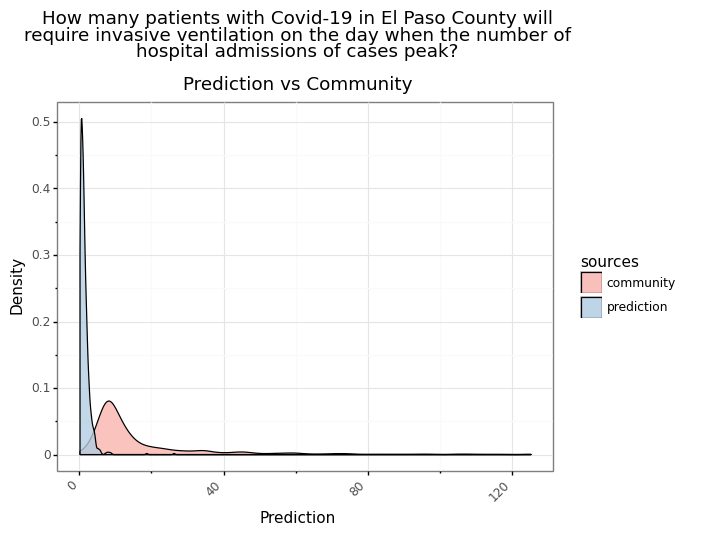

<ggplot: (-9223372036499298784)>


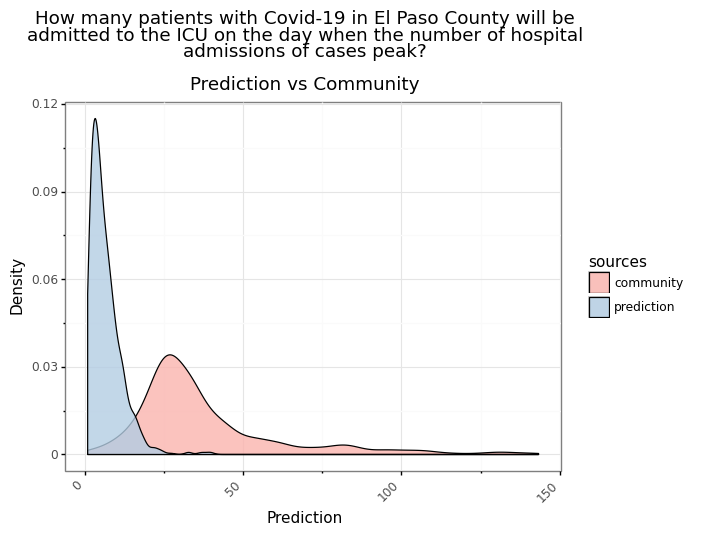

<ggplot: (354889690)>


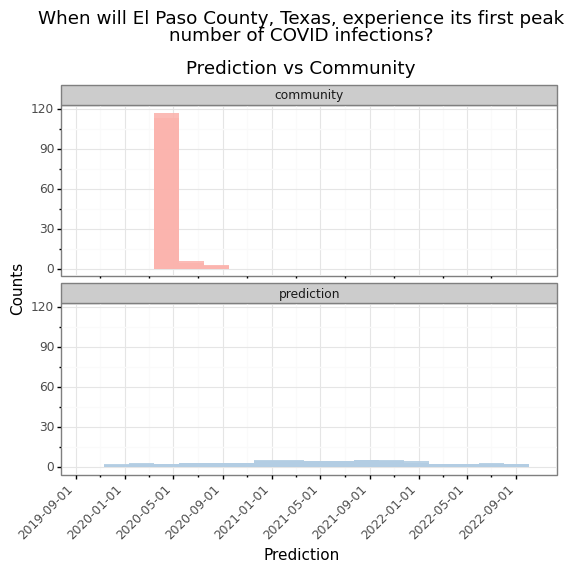

<ggplot: (355371612)>


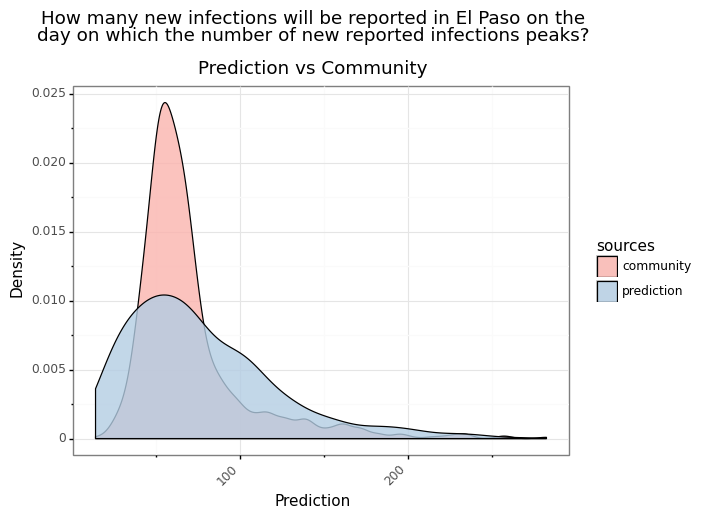

<ggplot: (-9223372036499034536)>


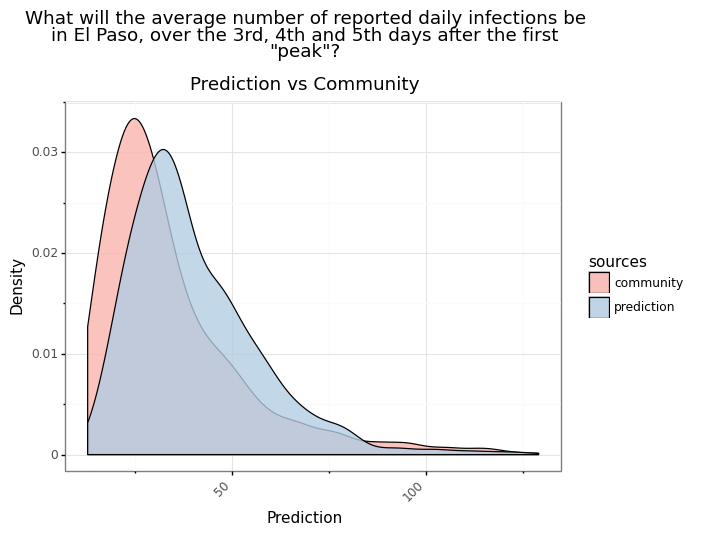

<ggplot: (-9223372036499017577)>


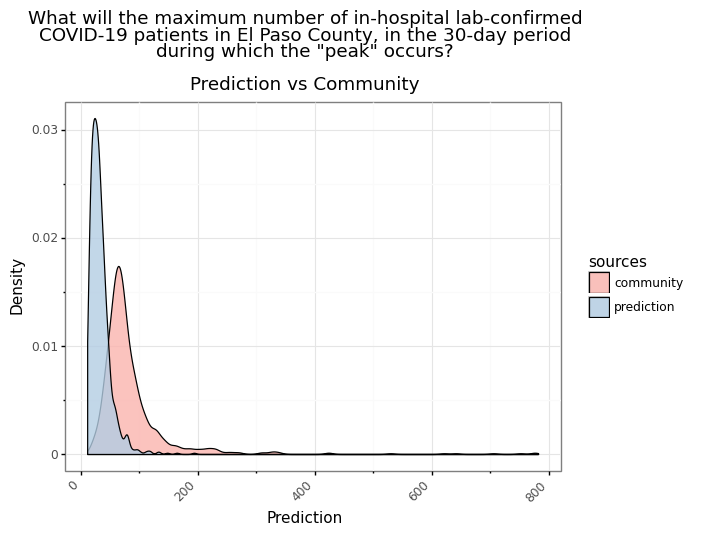

<ggplot: (-9223372036499091014)>


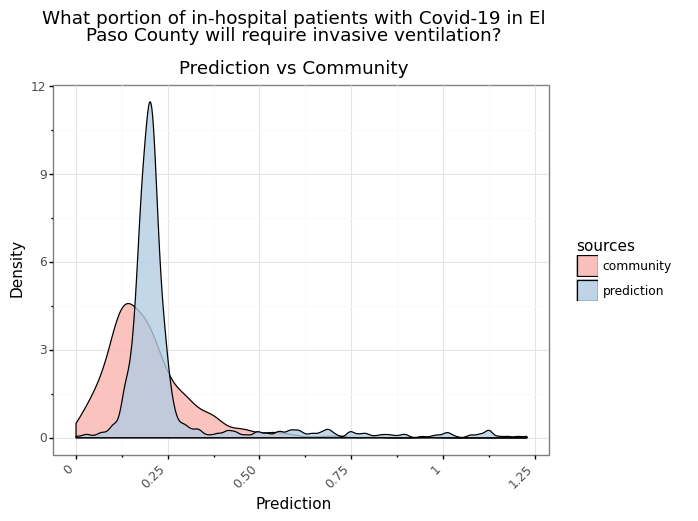

<ggplot: (-9223372036498906445)>


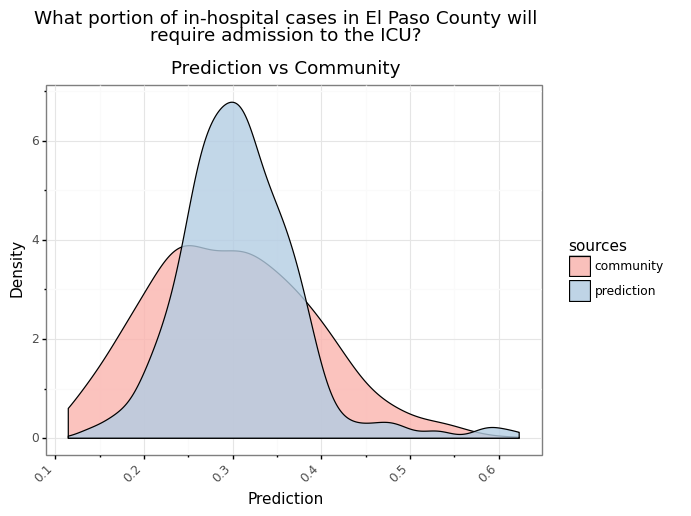

<ggplot: (-9223372036498990809)>


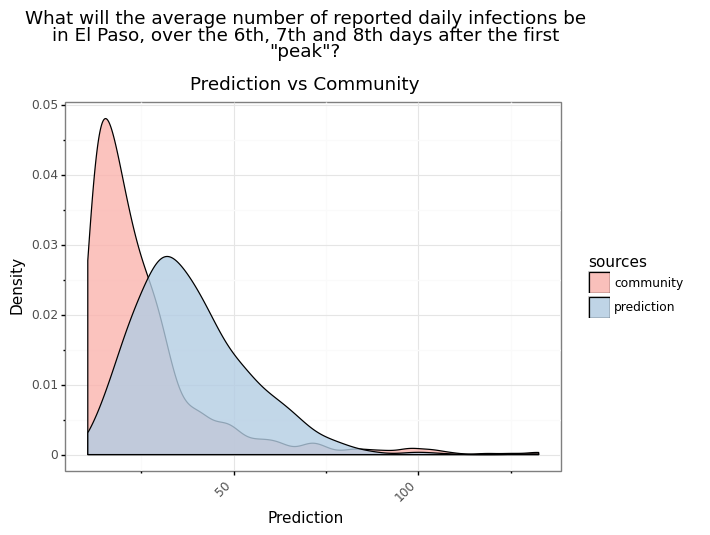

<ggplot: (355954857)>


In [16]:
import warnings
warnings.filterwarnings(module="plotnine", action="ignore")

for question in questions:
    key = str(question.id)
    if key != "4185": # unemployment question
        question.refresh_question() 
        print(question.show_prediction(samples=samples[str(question.id)], show_community=True))